In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

#### 2.2.1---Compute matching SIFT keypoints from a stereo image pair. (5 points)                                                                            
#### 2.2.2---Compute and display the epipolar lines for both images. (5 points)

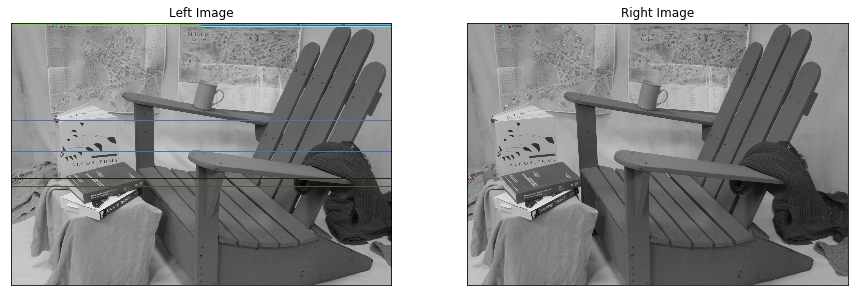

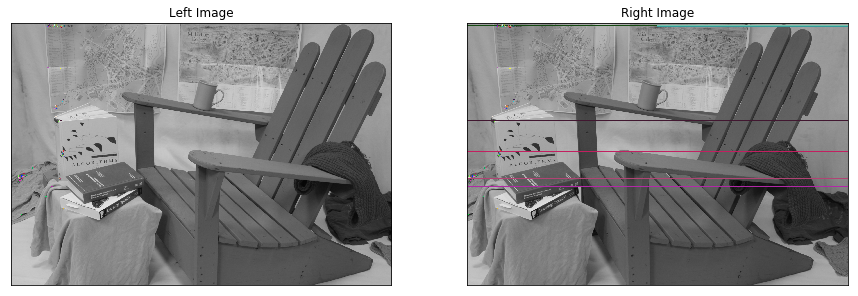

In [3]:
# load left and right images
dispL_path = './Adirondack-perfect/im0.png'
dispR_path = './Adirondack-perfect/im1.png'

# load left and right images
imgL = cv2.imread(dispL_path,cv2.IMREAD_GRAYSCALE);
imgR = cv2.imread(dispR_path,cv2.IMREAD_GRAYSCALE);


sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)


# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
        
# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL[:75], ptsL[:75], ptsR[:75])

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR[:75], ptsR[:75], ptsL[:75])


# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### 2.2.3---Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the right image. (2 points)
#### 2.2.4---Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image. (7 points)
#### 2.2.5---Plot SSD values (refer Lecture 14 slide 5). Find the matching point with minimum SSD value. Display found matching points in both the images. (4 points)

ptsR[45] position: [302 641]
Pixel Value of 5x5 patch from imageR:
[[127 128 129 133 138]
 [128 128 129 131 134]
 [114 113 113 113 116]
 [121 121 124 124 125]
 [130 132 133 131 130]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in ubyte_scalars


index min: 343
min SSD error: 1631
Pixel Value of Matched Patch Found using SSD:
[[135 131 135 142 146]
 [135 133 135 138 142]
 [127 124 124 126 130]
 [130 129 131 129 132]
 [133 134 139 137 135]]



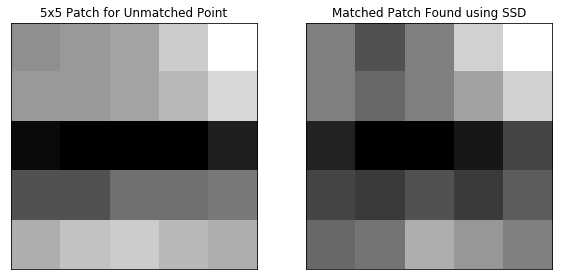

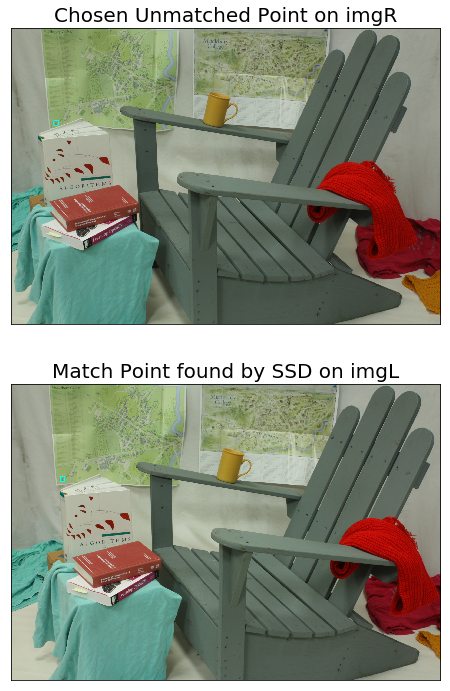

Text(0,0.5,'SSD of each Patch')

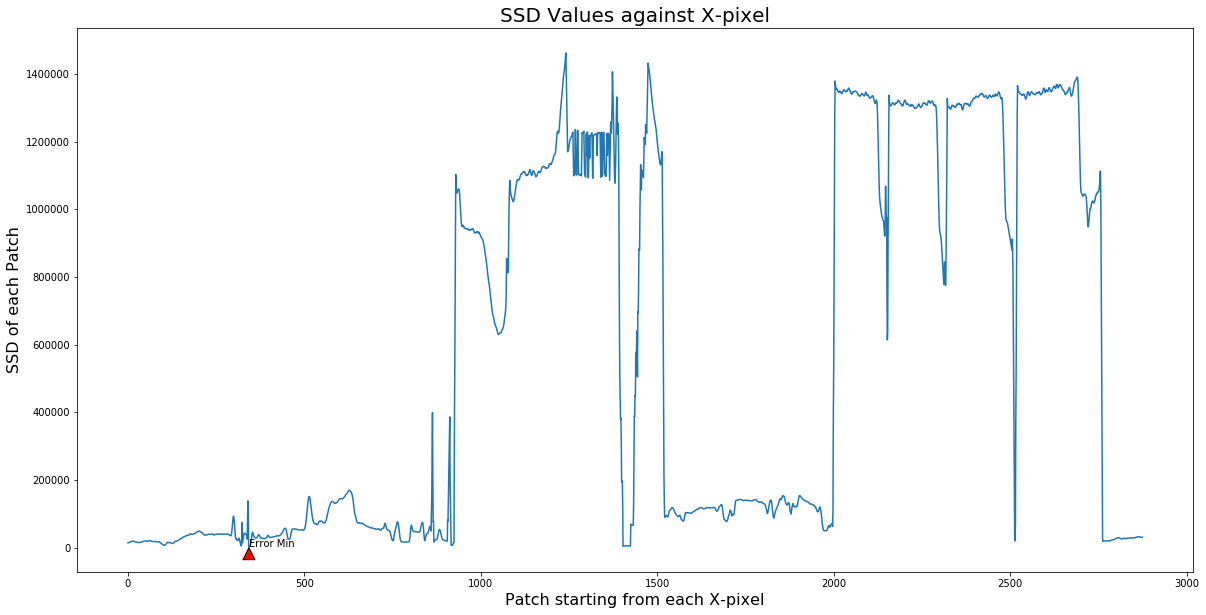

In [4]:
cv2.imwrite('imgR_epiline.png',imgR1)
cv2.imwrite('imgL_epiline.png',imgL1)

imgL = cv2.imread(dispL_path);
imgR = cv2.imread(dispR_path);

#  load the images as gray-scale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

print("ptsR[45] position:",ptsR[45])
keypointPosX = ptsR[45][0]
keypointPosY = ptsR[45][1]

# create the 5x5 keypoint patch from RIGHT image as reference
patch = imgR_gray[keypointPosY-2:keypointPosY+3, keypointPosX-2:keypointPosX+3]
print("Pixel Value of 5x5 patch from imageR:")
print(patch)

# create the 2880x5 strip from LEFT image for scanning
epiline_scan = imgL_gray[keypointPosY-2:keypointPosY+3,:]
ssd = 0
ssd_list = []

for i in range(epiline_scan.shape[1]-4):
    for y in range(5):
        for x in range(i,i+5):
            sd = np.power(epiline_scan[y,x]-patch[y,x-i],2)
            ssd = ssd + sd
    ssd_list.append(ssd)
    ssd = 0
    
# print("ssd_list size:",len(ssd_list))
indexMin = np.argmin(ssd_list)
print("index min:",indexMin)
print("min SSD error:",ssd_list[indexMin])

match_result = epiline_scan[:,indexMin:indexMin+5]
print("Pixel Value of Matched Patch Found using SSD:")
print(match_result) 
print("")
            
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(patch,cmap="gray")
plt.title("5x5 Patch for Unmatched Point"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(match_result,cmap="gray")
plt.title("Matched Patch Found using SSD"), plt.xticks([]), plt.yticks([])
plt.show()

# label the match points
cv2.rectangle(imgR, (keypointPosX-15,keypointPosY-15), (keypointPosX+15, keypointPosY+15), (255,255,0), 5)
cv2.rectangle(imgL, (indexMin-15,keypointPosY-15), (indexMin+15, keypointPosY+15), (255,255,0), 5)

plt.figure(figsize=(12,12))
plt.subplot(211), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Chosen Unmatched Point on imgR",fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Match Point found by SSD on imgL",fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()


# Plot the SSD values
plt.figure(figsize=(20,10))
x = np.arange(len(ssd_list))
plt.plot(x,ssd_list)
ymin = min(ssd_list)
xpos = np.argmin(ssd_list)
xmax = x[xpos]

plt.annotate('Error Min', xy=(xmax, ymin), xytext=(xmax, ymin+5),
             arrowprops=dict(facecolor='red', shrink=0.3),)

plt.title("SSD Values against X-pixel",fontsize=20)
plt.xlabel("Patch starting from each X-pixel",fontsize=16)
plt.ylabel("SSD of each Patch",fontsize=16)


#### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why. (2 points)

Only one point is found with lowest SSD. Fortunately, the matching point is the correct one and this is because the SSD approach finds the patch with smallest error, hence there's a large possibility that the output patch is the correct matching point. However, the SSD approach has many limitations. One of the limitations is that the SSD approach does not consider the distribution of error contribution from the pixels. 

For instance, if we have a 5x5 matching patch that has 1 pixel that has very large squared-difference error compared to the corresponding pixel in reference patch while the other 24 pixels have very small squared-difference, and a match patch with all 25 pixels having medium-to-large error. Given the condition that the second patch has smaller SSD error than the first patch, the SSD approach is more likely to output the second one as matching patch even though the first one is a closer match(visually speaking) to the reference patch. 

#### Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match? (1 point)
When we are sorting and selecting the good matches, we can set smaller distance range so that the keypoints we select are better matches. 


#### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match? (1 point)
In addition to scanning through the epipolar line, we could narrow down a region on the epipolar line where the match point should approximately be and only look for the match points in that region.

